# Notebook

**Authors:** Colin Small (crs1031@wildcats.unh.edu), Matthew Argall (Matthew.Argall@unh.edu), Marek Petrik (Marek.Petrik@unh.edu)

[![MMS Mission Video](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Artist_depiction_of_MMS_spacecraft_%28SVS12239%29.png/640px-Artist_depiction_of_MMS_spacecraft_%28SVS12239%29.png)](https://upload.wikimedia.org/wikipedia/commons/c/c9/NASA_Spacecraft_Finds_New_Magnetic_Process_in_Turbulent_Space.webm)

## Introduction
Global-scale energy flow throughout Earth’s magnetosphere is catalyzed by processes that occur at Earth’s magnetopause (MP) in the electron diffusion region (EDR) of magnetic reconnection. Until the launch of the Magnetospheric Multiscale (MMS) mission, only rare, fortuitous circumstances permitted a glimpse of the electron dynamics that break magnetic field lines and energize plasma. MMS employs automated burst triggers onboard the spacecraft and a  Scientist-in-the-Loop (SITL) on the ground to select intervals likely to contain diffusion regions. Only low-resolution survey data is available to the SITL, which is insufficient to resolve electron dynamics. A strategy for the SITL, then, is to select all MP crossings. This has resulted in over 35 potential MP EDR encounters but is labor- and resource-intensive; after manual reclassification, just ∼ 0.7% of MP crossings, or 0.0001% of the mission lifetime during MMS’s first two years contained an EDR.

In this notebook, we develop a Long-Short Term Memory (LSTM) neural network to detect magnetopause crossings and automate the SITL classification process. An LSTM developed with this notebook has been implemented in the MMS data stream to provide automated predictions to the SITL.


This model facilitates EDR studies and helps free-up mission operation costs by consolidating manual classification processes into automated routines.

**Authors' notes:** 

1. This notebook was developed after the development of the original model in use at the SDC. We have tried our best to replicate the development steps and hyperparameters of that model, but we cannot guarantee that models developed with this notebook will exactly match the performance of the original.

2. This notebook was designed on, and is best run on, Google Colab. It must either be run on Colab or on a machine with an NVIDIA GPU and cuDNN installed. If your machine does not have an NVIDIA GPU, does not have cuDNN installed, or if you run into issues running this notebook yourself, please open the notebook in Google Colab, which provides you with a virtual GPU to run the notebook. (If TF Keras is unable to identify a GPU to run on, make sure the notebook is set to use one by clicking the "Runtime" tab in the top menu bar, selecting "Change runtime type", selecting "GPU" in the dropdown menu under "Hardware accelerator", and clicking save. Colab will refresh your timetime, and you will need to re-run all cells.):

<a href="https://colab.research.google.com/drive/1Mh7GEQfXCR5xKvtKmbG9Uh8yAlOtFgwO?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Import Libraries

To start, we import the neccesary libraries for this notebook.

In [1]:
!pip install nasa-pymms

In [2]:
from pathlib import Path
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Bidirectional, Reshape, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras import backend as K
from pymms.sdc import mrmms_sdc_api as mms
import keras.backend.tensorflow_backend as tfb
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import datetime as dt
import os
import time
import sklearn
import scipy
import pickle
import random
import requests

ModuleNotFoundError: No module named 'tensorflow'

## Download, Preprocess, and Format MMS Data

After installing and importinng the neccesary libraries, we download our training and validation data. 

In [3]:
!wget -O training_data.csv https://zenodo.org/record/3884266/files/original_training_data.csv?download=1
!wget -O validation_data.csv https://zenodo.org/record/3884266/files/original_validation_data.csv?download=1

--2020-09-16 16:36:14--  https://zenodo.org/record/3884266/files/original_training_data.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447842635 (427M) [text/plain]
Saving to: ‘training_data.csv’

training_data.csv   100%[===================>] 427.10M  7.45MB/s    in 24s     

2020-09-16 16:36:39 (18.0 MB/s) - ‘training_data.csv’ saved [447842635/447842635]

--2020-09-16 16:36:39--  https://zenodo.org/record/3884266/files/original_validation_data.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90314951 (86M) [text/plain]
Saving to: ‘validation_data.csv’

validation_data.csv 100%[===================>]  86.13M  8.10MB/s    in 10s     

2020-09-16 16:36:49 (8.45 MB/s) - ‘validation_data.csv’ saved

After downloading the training and validation data, we preprocess our training data in preparation for training the neural network.

We first load the data we downloaded above. The data is a table of measurements from the MMS spacecraft, where each row represents individual measurements taken at a given time and where each column represents a feature (variable) recorded at that time. There is an additional column representing the ground truths for each measurement (whether this measurement was selected by a SITL or not). Then, we will adjust the formatting and datatypes of several of the columns and sort the data by the time of the measurement.

In [4]:
mms_data = pd.read_csv('training_data.csv', index_col=0, infer_datetime_format=True,
						   parse_dates=[0])

In [5]:
mms_data[mms_data['selected'] == False]

,mms1_des_energyspectr_omni_fast_0,mms1_des_energyspectr_omni_fast_1,mms1_des_energyspectr_omni_fast_2,mms1_des_energyspectr_omni_fast_3,mms1_des_energyspectr_omni_fast_4,mms1_des_energyspectr_omni_fast_5,mms1_des_energyspectr_omni_fast_6,mms1_des_energyspectr_omni_fast_7,mms1_des_energyspectr_omni_fast_8,mms1_des_energyspectr_omni_fast_9,mms1_des_energyspectr_omni_fast_10,mms1_des_energyspectr_omni_fast_11,mms1_des_energyspectr_omni_fast_12,mms1_des_energyspectr_omni_fast_13,mms1_des_energyspectr_omni_fast_14,mms1_des_energyspectr_omni_fast_15,mms1_des_energyspectr_omni_fast_16,mms1_des_energyspectr_omni_fast_17,mms1_des_energyspectr_omni_fast_18,mms1_des_energyspectr_omni_fast_19,mms1_des_energyspectr_omni_fast_20,mms1_des_energyspectr_omni_fast_21,mms1_des_energyspectr_omni_fast_22,mms1_des_energyspectr_omni_fast_23,mms1_des_energyspectr_omni_fast_24,mms1_des_energyspectr_omni_fast_25,mms1_des_energyspectr_omni_fast_26,mms1_des_energyspectr_omni_fast_27,mms1_des_energyspectr_omni_fast_28,mms1_des_energyspectr_omni_fast_29,mms1_des_energyspectr_omni_fast_30,mms1_des_numberdensity_fast,mms1_des_bulkv_dbcs_fast_0,mms1_des_bulkv_dbcs_fast_1,mms1_des_heatq_dbcs_fast_0,mms1_des_heatq_dbcs_fast_1,mms1_des_temppara_fast,mms1_des_tempperp_fast,mms1_des_prestensor_dbcs_fast_x1_y1,mms1_des_prestensor_dbcs_fast_x2_y1,...,mms1_dis_energyspectr_omni_fast_29,mms1_dis_energyspectr_omni_fast_30,mms1_dis_numberdensity_fast,mms1_dis_bulkv_dbcs_fast_0,mms1_dis_bulkv_dbcs_fast_1,mms1_dis_heatq_dbcs_fast_0,mms1_dis_heatq_dbcs_fast_1,mms1_dis_temppara_fast,mms1_dis_tempperp_fast,mms1_dis_prestensor_dbcs_fast_x1_y1,mms1_dis_prestensor_dbcs_fast_x2_y1,mms1_dis_prestensor_dbcs_fast_x2_y2,mms1_dis_prestensor_dbcs_fast_x3_y1,mms1_dis_prestensor_dbcs_fast_x3_y2,mms1_dis_prestensor_dbcs_fast_x3_y3,mms1_dis_temptensor_dbcs_fast_x1_y1,mms1_dis_temptensor_dbcs_fast_x2_y1,mms1_dis_temptensor_dbcs_fast_x2_y2,mms1_dis_temptensor_dbcs_fast_x3_y1,mms1_dis_temptensor_dbcs_fast_x3_y2,mms1_dis_temptensor_dbcs_fast_x3_y3,mms1_dis_temp_anisotropy,mms1_dis_scalar_temperature,mms1_dis_N_Q,mms1_dis_Vz_Q,mms1_dis_nV_Q,mms1_afg_srvy_dmpa_Bx,mms1_afg_srvy_dmpa_By,mms1_afg_srvy_dmpa_Bz,mms1_afg_srvy_dmpa_|B|,mms1_afg_magnetic_pressure,mms1_afg_clock_angle,mms1_afg_Bz_Q,mms1_edp_x,mms1_edp_y,mms1_edp_z,mms1_edp_|E|,mms1_temp_ratio,mms1_plasma_beta,selected
Epoch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 01:49:08.736524,172560370.0,141811650.0,115564310.0,103489660.0,109156240.0,138017710.0,199794740.0,313011970.0,495821400.0,7.675890e+08,1.102645e+09,1.355750e+09,1.283706e+09,876457860.0,437018100.0,178497440.0,61324772.0,17706034.0,5950672.0,1453186.0,1230702.8,1290793.0,1361365.00,1443553.0,1538581.10,1600447.1,1693706.6,1860683.8,1821310.1,1785482.6,2143655.0,47.289574,-64.066220,-59.850384,0.067417,-0.033087,68.663414,69.643720,0.530681,0.000513,...,1847614.4,1368769.60,45.166210,-65.301070,-75.960210,-0.017214,-0.054081,496.30145,558.62010,4.105384,0.039305,3.979379,0.077544,0.372712,3.591420,4.105384,0.039305,3.979379,0.077544,0.372712,3.591420,-0.111558,537.84720,0.000000,0.000000,5217.443037,-0.026197,33.162117,-39.656940,51.695260,2.126628e+09,1.571586,1.467709,-0.862275,1.665013,0.827068,2.049348,1.0,524.89600,False
2017-01-01 01:49:13.236552,160474430.0,134115120.0,113082936.0,106597736.0,118977260.0,157128700.0,234196500.0,368190240.0,588617700.0,9.143196e+08,1.280595e+09,1.386385e+09,1.020292e+09,546922600.0,238565300.0,95543030.0,34221956.0,10795790.0,3346869.8,1132098.6,1230606.6,1290689.8,1370548.60,1217164.6,1303508.00,1396131.6,1496823.2,1930027.9,1878429.5,675747.1,2085773.5,47.806107,-34.529873,-128.342510,0.091984,-0.000412,59.059840,62.034630,0.473132,0.000187,...,1385553.0,1053661.50,46.629120,-60.415287,-118.971080,-0.003761,0.163968,415.75192,523.83150,3.883746,0.074054,3.943084,0.049551,0.003202,3.105979,3.883746,0.074054,3.943084,0.049551,0.003202,3.105979,-0.206325,487.80496,1.097182,39.256162,603

We save references to data's index and column names for later use and additionally pop off the ground truths column. We will reattach the ground truths column after standardizing and interpolating the data.

In [6]:
index = mms_data.index
selections = mms_data.pop("selected")
column_names = mms_data.columns

Since there exists a possibility that the training contains missing data or data misreported by the MMS spacecraft (reported as either infinity or negative infinity), we need to fill in (interpolate) any missing data.

In [7]:
mms_data = mms_data.replace([np.inf, -np.inf], np.nan)
mms_data = mms_data.interpolate(method='time', limit_area='inside')

We normalize all features with standardization:

![z = (x - u) / s ](https://wikimedia.org/api/rest_v1/media/math/render/svg/b0aa2e7d203db1526c577192f2d9102b718eafd5)

Where x̄ is the mean of the data, and σ is the standard deviation of the data.

Normalization ensures that the numerical values of all features of the data fall within a range from one to negative one and are centered around their mean (zero-mean and unit variance). Normalization improves the speed and performance of training neural networks as it unifies the scale by which differences in the data are represented without altering the data themselves.

In [8]:
scaler = preprocessing.StandardScaler()
mms_data = scaler.fit_transform(mms_data)
mms_data = pd.DataFrame(mms_data, index, column_names)
mms_data = mms_data.join(selections)

Next, we calculate class weights for our data classes (selected data points and non-selected data points). Since the distribution of our data is heavily skewed towards non-selected data points (just 1.9% of all data points in our training data were selected), it's important to give the class of selected data points a higher weight when training. In fact, without establishing these class weights our model would quickly acheive 98% accuracy by naively leaving all data points unselected.

In [9]:
false_weight = len(mms_data)/(2*np.bincount(mms_data['selected'].values)[0])
true_weight = len(mms_data)/(2*np.bincount(mms_data['selected'].values)[1])

Our entire dataset is not contigous, and it contains time intervals with no observations. Therefore, we break it up into contigous chunks. We can do so by breaking up the data into the windows that the SITLs used to review the data.

In [10]:
sitl_windows = mms.mission_events('sroi', mms_data.index[0].to_pydatetime(), mms_data.index[-1].to_pydatetime(), sc='mms1')
windows = []
for start, end in zip(sitl_windows['tstart'], sitl_windows['tend']):
  window = mms_data[start:end]
  if not window.empty and len(window[window['selected']==True])>1:
    windows.append(window)

In [11]:
windows

[                            mms1_des_energyspectr_omni_fast_0  ...  selected
 Epoch                                                          ...          
 2017-01-01 01:49:31.236651                           1.883959  ...     False
 2017-01-01 01:49:35.736674                           1.458570  ...     False
 2017-01-01 01:49:40.236701                           1.368072  ...     False
 2017-01-01 01:49:44.736723                           1.338055  ...     False
 2017-01-01 01:49:49.236750                           1.660276  ...     False
 ...                                                       ...  ...       ...
 2017-01-01 15:42:28.613021                          -0.710802  ...     False
 2017-01-01 15:42:33.113061                          -0.251731  ...     False
 2017-01-01 15:42:37.613092                          -0.093185  ...     False
 2017-01-01 15:42:42.113131                          -0.247850  ...     False
 2017-01-01 15:42:46.613161                          -0.708025  

Finally, we break up our data into individual sequences that will be fed to our neural network.

We define a SEQ_LEN variable that will determine the length of our sequences. This variable will also be passed to our network so that it knows how long of a data sequence to expect while training. The choice of sequence length is largely arbitrary.

In [12]:
SEQ_LEN = 250

For each window, we assemble two sequences: an X_sequence containing individual data points from our training data and a y_sequence containing the truth values for those data points (whether or not those data points were selected by a SITL). 

We add those sequences to four collections: X_train and y_train containing X_sequences and y_sequences for our training data and X_test and y_test containing X_sequences and y_sequences for our testing data. We allocate 80% of the sequences to trainining and the remaining 20% to testing. 

In [13]:
 while True:
    X_train, X_test, y_train, y_test = [], [], [], []

    sequences = []
    for i in range(len(windows)):
      X_sequence = []
      y_sequence = []

      if random.random() < 0.6:
        for value in windows[i].values:
          X_sequence.append(value[:-1])
          y_sequence.append(value[-1])
          if len(X_sequence) == SEQ_LEN:
            X_train.append(X_sequence.copy())
            
            y_train.append(y_sequence.copy())

            X_sequence = []
            y_sequence = []

      else:
        for value in windows[i].values:
          X_sequence.append(value[:-1])
          y_sequence.append(value[-1])
          if len(X_sequence) == SEQ_LEN:
            X_test.append(X_sequence.copy())
            
            y_test.append(y_sequence.copy())

            X_sequence = []
            y_sequence = []

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.expand_dims(np.array(y_train), axis=2)
    y_test = np.expand_dims(np.array(y_test), axis=2)

    if len(X_train) > len(X_test):
        break

We can see how many sequences of data we have for training and testing, respectively:

In [14]:
print(f"Number of sequences in training data: {len(X_train)}")
print(f"Number of sequences in test data: {len(X_test)}")

Number of sequences in training data: 753
Number of sequences in test data: 519


## Define and Train LSTM

Now that we have processed our data into our training and test sets, we can begin to build and train and our LSTM.

First, we need to define a custom F1 score and weighted binary crossentropy functions.

An F1 score is a measure of a model's accuracy, calculated as a balance of the model's precision (the number of true positives predicted by the model divided by the total number of positives predicted by the model) and recall (the number of true positives predicted by the model divided by the number of actual positives in the data):

![F1 = 2 * (precision * recall) / (precision + recall)](https://wikimedia.org/api/rest_v1/media/math/render/svg/1bf179c30b00db201ce1895d88fe2915d58e6bfd)

We will evaluate our model using the F1 score since we want to strike a balance between the model's precision and recall. Remember, we cannot use true accuracy (the number of true positives and true negatives divided by the number of data points in the data) because of the imbalance between our classes.


In [15]:
# (Credit: Paddy and Kev1n91 from https://stackoverflow.com/a/45305384/3988976)
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Cross-entropy is a function used to determine the loss between a set of predictions and their truth values. The larger the difference between a prediction and its true value, the larger the loss will be. In general, many machine learning architectures (including our LSTM) are designed to minimize their given loss function. A perfect model will have a loss of 0.

Binary cross-entropy is used when we only have two classes (in our case, selected or not selected) and weighted binary cross-entropy allows us to assign a weight to one of the classes. This weight can effectively increase or decrease the loss of that class. In our case, we have previously defined a variable *true_weight* to be the class weight for positive (selected) datapoints. We will pass that weight into the function.

This cross-entropy function will be passed in to our model as our loss function.

(Because the loss function of a model needs to be differentiable to perform gradient descent, we cannot use our F1 score as our loss function.)

In [16]:
# (Credit: tobigue from https://stackoverflow.com/questions/42158866/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu)
def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
                                                    logits=output,
                                                    pos_weight=true_weight)
    return tf.reduce_mean(loss, axis=-1)

Before building our LSTM, we define several hyperparameters that will define how the model is trained:

EPOCHS: The number of times the model trains through our entire dataset

BATCH_SIZE: The number of sequences that our model trains using at any given point

LAYER_SIZE: The number of LSTM internal to each layer of the model.

Choices for these hyperparameters are largely arbitrary and can be altered to tune our LSTM.

In [17]:
EPOCHS = 100
BATCH_SIZE = 128
LAYER_SIZE = 300

We now define our LSTM.

For this version of the model, we two bidirectional LSTM layers, two dropout layers, and one time distributed dense layer.

Internally, an LSTM layer uses a for loop to iterate over the timesteps of a sequence, while maintaining states that encode information from those timesteps. Using these internal states, the LSTM learns the characteristics of our data (the X_sequences we defined earlier) and how those data relate to our expected output (the y_sequences we defined earlier). Normal (unidirectional) LSTMs only encode information from prior-seen timesteps. Bidirectional LSTMs can can encode information prior to and after a given timestep.

With the addition of a dense layer, the LSTM will output a value between 0 and 1 that corresponds to the model's certainty about whether or not a timestep was selected by the SITL.


In [18]:
model_name = f"{SEQ_LEN}-SEQ_LEN-{BATCH_SIZE}-BATCH_SIZE-{LAYER_SIZE}-LAYER_SIZE-{int(time.time())}"

model = Sequential()

model.add(Bidirectional(LSTM(LAYER_SIZE, return_sequences=True), input_shape=(None, X_train.shape[2])))

model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(LAYER_SIZE, return_sequences=True), input_shape=(None, X_train.shape[2])))

model.add(Dropout(0.4))

model.add(TimeDistributed(Dense(1, activation='sigmoid')))

opt = tf.keras.optimizers.Adam()

model.compile(loss=weighted_binary_crossentropy,
        optimizer=opt,
        metrics=['accuracy', f1, tf.keras.metrics.Precision()])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
targets is deprecated, use labels instead


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 600)         1017600   
_________________________________________________________________
dropout (Dropout)            (None, None, 600)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 600)         2162400   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 600)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           601       
Total params: 3,180,601
Trainable params: 3,180,601
Non-trainable params: 0
_________________________________________________________________


We set our training process to save the best versions of our model according to the previously defined F1 score. Each epoch, if a version of the model is trained with a higher F1 score than the previous best, the model saved on disk will be overwritten with the current best model.

In [20]:
filepath = "mp-dl-unh" 
checkpoint = ModelCheckpoint(filepath, monitor='val_f1', verbose=1, save_best_only=True, mode='max')

The following will train the model and save the training history for later visualization.

In [21]:
history = model.fit(
  x=X_train, y=y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test, y_test),
  callbacks=[checkpoint],
  verbose=1,
  shuffle=False
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 753 samples, validate on 519 samples
Epoch 1/100
640/753 [========================>.....] - ETA: 1s - loss: 0.8397 - acc: 0.6974 - f1: 0.3451 - precision: 0.1849
Epoch 00001: val_f1 improved from -inf to 0.42757, saving model to mp-dl-unh
753/753 [==============================] - 15s 19ms/sample - loss: 0.7737 - acc: 0.7232 - f1: 0.3541 - precision: 0.1909 - val_loss: 0.6396 - val_acc: 0.8299 - val_f1: 0.4276 - val_precision: 0.2014
Epoch 2/100
640/753 [========================>.....] - ETA: 1s - loss: 0.6136 - acc: 0.8747 - f1: 0.5461 - precision: 0.3894
Epoch 00002: val_f1 did not improve from 0.42757
753/753 [==============================] - 11s 14ms/sample - loss: 0.5620 - acc: 0.8849 - f1: 0.5549 - precision: 0.3958 - val_loss: 0.5994 - val_acc: 0.8189 - val_f1: 0.2793 - val_precision: 0.1862
Epoch 3/100
640/753 [========================>.....] - ETA: 1s - loss: 0.5949 - acc: 0

## Performance Visualization

To evaluate the training of our model over time, we visualize the model's loss on its training and testing data.

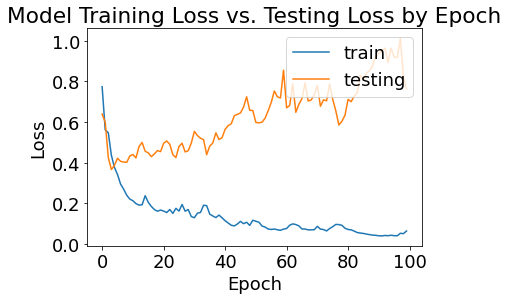

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss vs. Testing Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

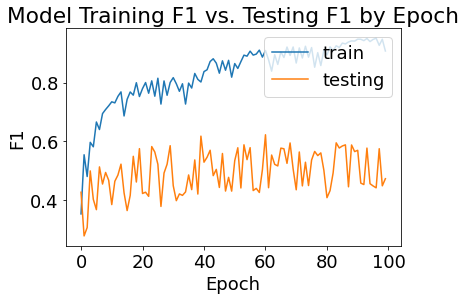

In [23]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model Training F1 vs. Testing F1 by Epoch')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

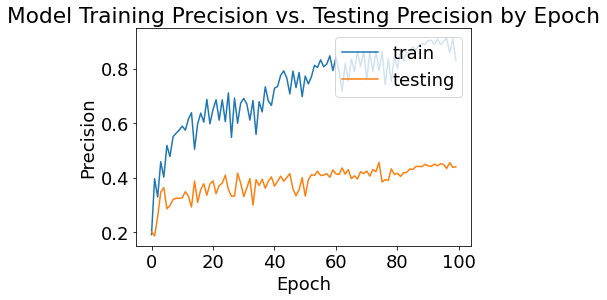

In [24]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Training Precision vs. Testing Precision by Epoch')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

(We can see that the model performs much better on its training data. This is expected, as the model learns to recreate the selections of the training data. We can also see that the performance of the model on the testing data decreases over time. This is evidence of the model overfitting. At some point, the model begins to naively recreate the selections of the training data rather than truly learning how to make selections. In practice, we effectively ignore this as we have already saved the version of the model with the best performance on the testing data - mitigating any overfitting.)

In [25]:
model = tf.keras.models.load_model('/content/mp-dl-unh', {'weighted_binary_crossentropy':weighted_binary_crossentropy, 'f1':f1})

## Model Performance Visualization

Now that we have trained the model, we will visualize its selection-making ability compared to the SITLs.

Since we've already preprocessed the testing/training data into a format suitable for model training, we reload that data to preprocess it into a format suitable for evaluation.

In [26]:
validation_data = pd.read_csv('training_data.csv', index_col=0, infer_datetime_format=True,
						   parse_dates=[0])

We apply the same preprocessing steps to this data as we did for the original training and testing data.

In [27]:
index = validation_data.index
selections = validation_data.pop("selected")
column_names = validation_data.columns

In [28]:
validation_data = validation_data.replace([np.inf, -np.inf], np.nan)
validation_data = validation_data.interpolate(method='time', limit_area='inside')

In [29]:
validation_data = scaler.transform(validation_data)
validation_data = pd.DataFrame(validation_data, index, column_names)
validation_data = validation_data.join(selections)

In [30]:
validation_X = validation_data.values[:,:-1]
validation_y = validation_data.values[:,-1]

Using the model we trainend earlier, we make test predctions on our validation data.

In [31]:
test_predictions = model.predict(np.expand_dims(validation_X, axis=0))

We visualize the true SITL selections made over the validation data by plotting the ground truth values for each datapoint in the data (where a 1 denotes that an individual datapoint was selected and a 0 denotes that it wasn't).


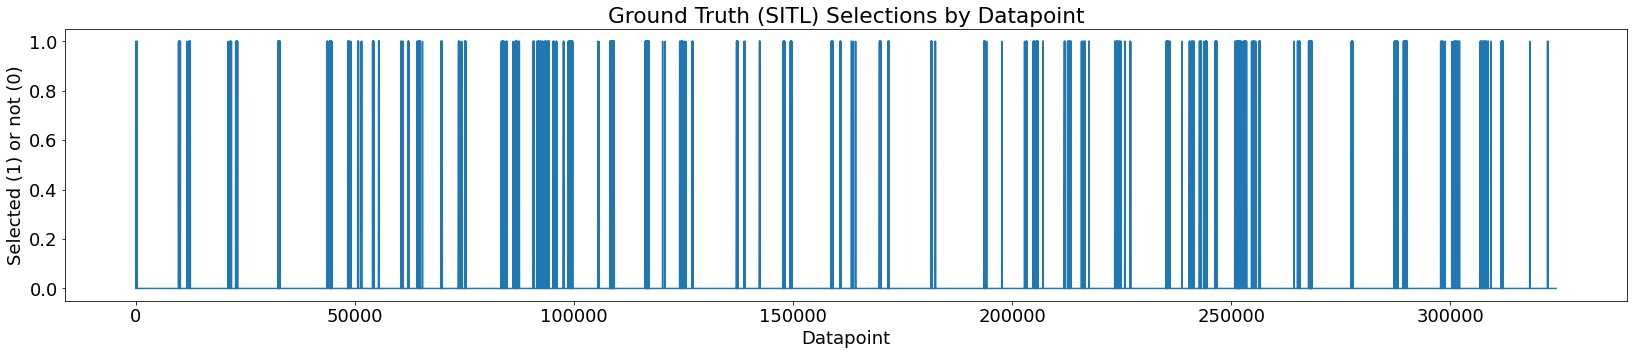

In [32]:
plt.figure(figsize=(28, 5))
plt.plot(validation_y.astype(int))
plt.title("Ground Truth (SITL) Selections by Datapoint")
plt.ylabel('Selected (1) or not (0)')
plt.xlabel('Datapoint')
plt.show()

...and we do the same for the model's predictions.

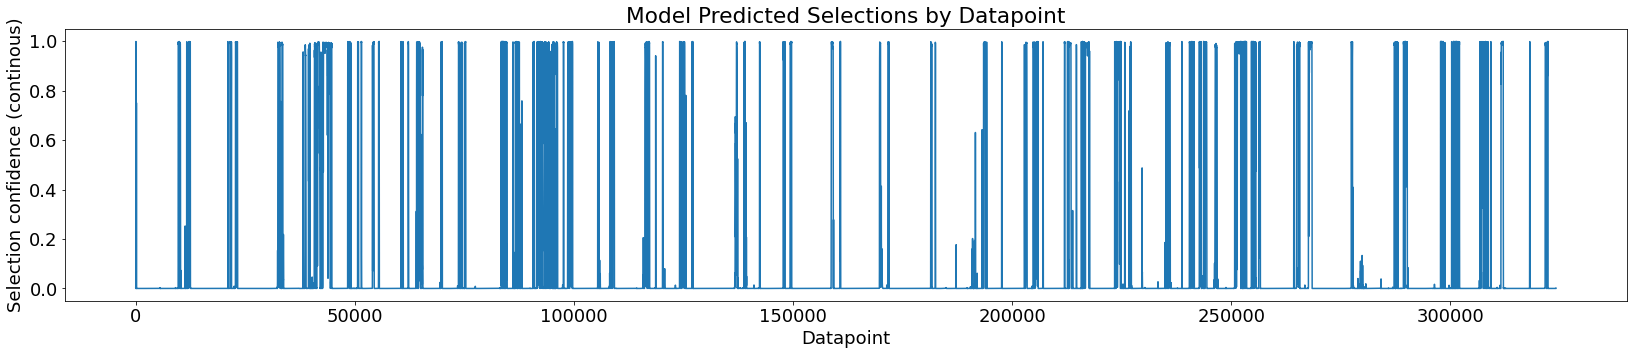

In [33]:
plt.figure(figsize=(28, 5))
plt.plot(test_predictions.squeeze())
plt.title("Model Predicted Selections by Datapoint")
plt.ylabel('Selection confidence (continous)')
plt.xlabel('Datapoint')
plt.show()

From this plot, we can see the continuous nature of the model's predictions. As mentioned earlier, the model outputs a continuous value between 0 and 1 for each datapoint that(very roughly) corresponds to its confidence in the selection of a point (i.e. an outputted value of 0.95 for a datapoint roughly means that the model is 95% certain that that point should be selected).

With this in mind, we filter the model's predictions so that only those predictions with a >= 50% probability of being a magnetopause crossing are kept. This choice of probability/certainty is known as the threshold. 

This choice of threshold is chosen to optimize between over-selecting datapoints (resulting in more false-positives) and under-selecting them (resulting in more false-negatives).

As an example, consider an email server's spam-detection system. Such a system might have a fairly high threshold (>99%), as you don't want to accidentally send a user's non-spam email to their spam inbox. At the same time, it's okay if a handful of spam emails make it through their regular inbox.

In our case, we can afford to over-select datapoints as we do not want to miss out on any potential magnetopause crossings.

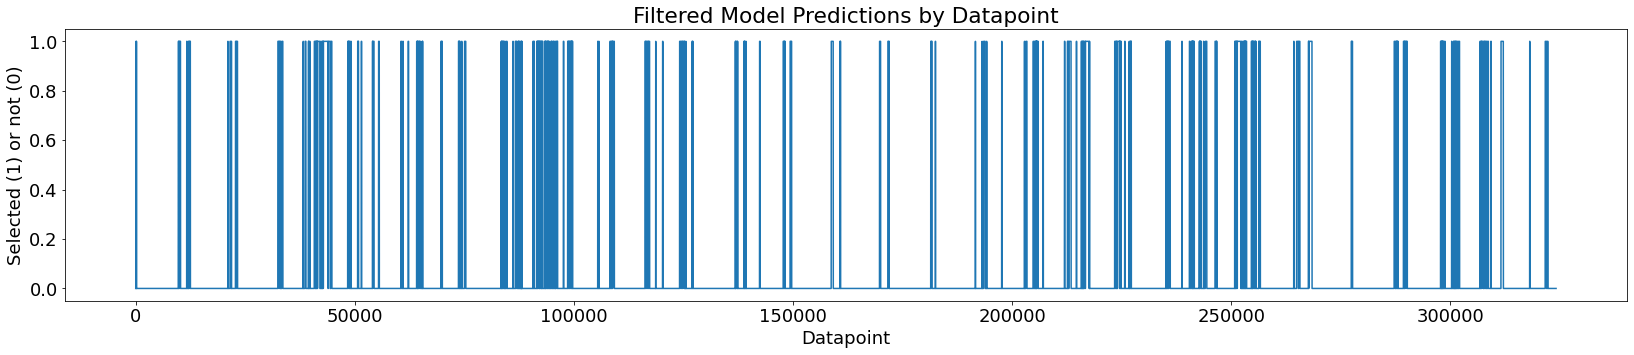

In [34]:
t_output = [0 if x < 0.5 else 1 for x in test_predictions.squeeze()]
plt.figure(figsize=(28, 5))
plt.plot(t_output)
plt.title("Filtered Model Predictions by Datapoint")
plt.ylabel('Selected (1) or not (0)')
plt.xlabel('Datapoint')
plt.show()

## Model Validation

Although we have already validated our model on data it has not seen (the testing set), we need to make sure that its ability to select magnetopause crossings is transferable to another range of data.

We load a third set of data, the validation set, which serves as an independent check on the model. 

In [35]:
validation_data = pd.read_csv('validation_data.csv', index_col=0, infer_datetime_format=True,
						   parse_dates=[0])

We apply the same preprocessing steps to the validation data as we did for the training and testing data.

In [36]:
index = validation_data.index
selections = validation_data.pop("selected")
column_names = validation_data.columns

In [37]:
validation_data = validation_data.replace([np.inf, -np.inf], np.nan)
validation_data = validation_data.interpolate(method='time', limit_area='inside')

However, we standardize the validation data to the scale of the training/testing data.

In [38]:
validation_data = scaler.transform(validation_data)
validation_data = pd.DataFrame(validation_data, index, column_names)
validation_data = validation_data.join(selections)

In [39]:
validation_X = validation_data.values[:,:-1]
validation_y = validation_data.values[:,-1]

Using the model we trained earlier, we make test predctions on our validation data.

In [40]:
test_predictions = model.predict(np.expand_dims(validation_X, axis=0))

We visualize the true SITL selections made over the validation data in the same way we did above.


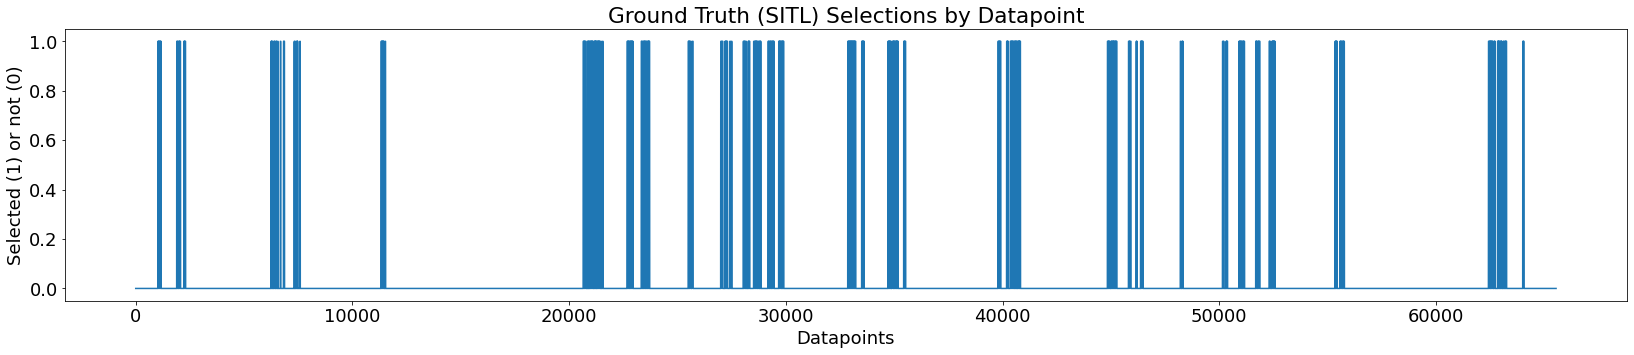

In [41]:
plt.figure(figsize=(28, 5))
plt.plot(validation_y.astype(int))
plt.title("Ground Truth (SITL) Selections by Datapoint")
plt.ylabel('Selected (1) or not (0)')
plt.xlabel('Datapoints')
plt.show()

...and we do the same for the model's predictions.

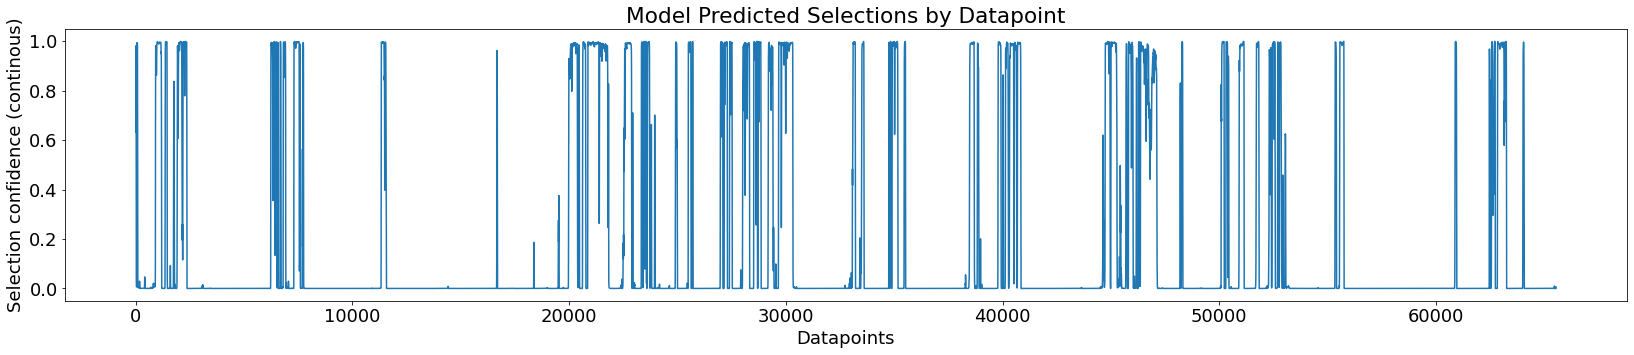

In [42]:
plt.figure(figsize=(28, 5))
plt.plot(test_predictions.squeeze())
plt.title("Model Predicted Selections by Datapoint")
plt.ylabel('Selection confidence (continous)')
plt.xlabel('Datapoints')
plt.show()

Once again, we filter the model's predictions so that only those predictions with a >= 50% probability of being a magnetopause crossing are kept.

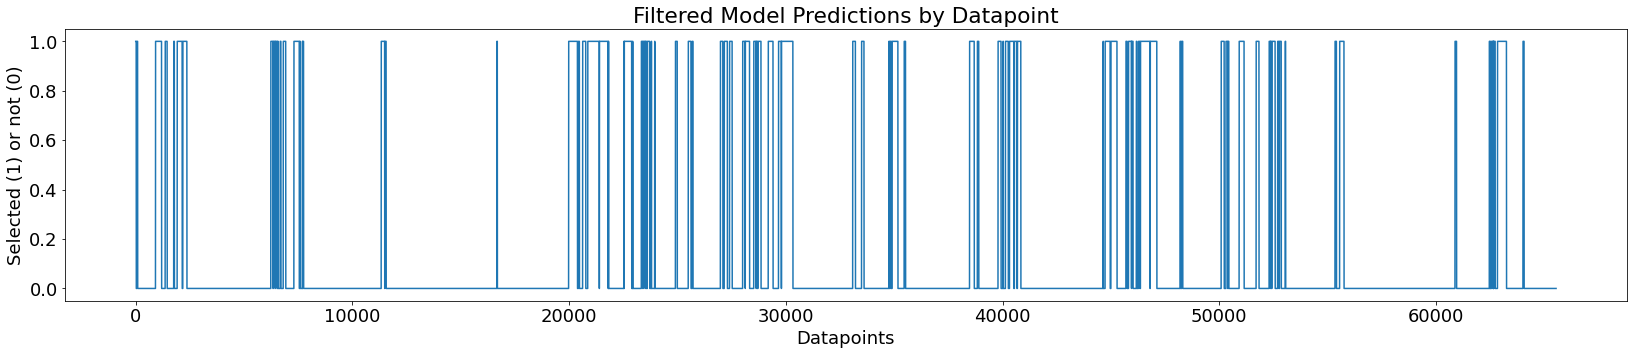

In [43]:
t_output = [0 if x < 0.5 else 1 for x in test_predictions.squeeze()]
plt.figure(figsize=(28, 5))
plt.plot(t_output)
plt.title("Filtered Model Predictions by Datapoint")
plt.ylabel('Selected (1) or not (0)')
plt.xlabel('Datapoints')
plt.show()

We now plot a receiver operating characteristic (ROC) curve based on the model's performance over the evaluation data. 

An ROC curve will plot a model's true-positive vs. false positive rates of predictions for varying choices of thresholds. As the threshold approaches 1, the false positive rate and the true positive rates approach 0, as every prediction made is over the threshold and is thus considered a selection. As the threshold approaches 1, the false positive rate and the true positive rates approach 0, as no prediction made surpasses the threshold of 1.

While we can use the plot to determine where we want to set our threshold (considering the importance of under-selecting or over-selecting points), it is more often used to get a sense of the performance of our model.

To do so, we calculate the total area under the ROC curve. This area is equal to the probability that the model will output a higher prediction value for a randomly chosen datapoint whose ground truth was "selected" than for a randomly chosen datapoint whose ground truth value was "not selected".

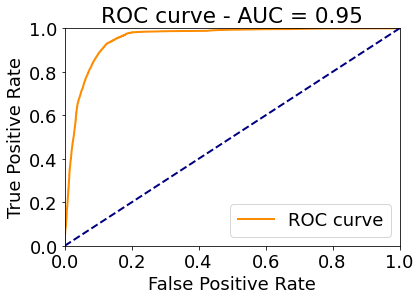

In [44]:
fpr, tpr, thresholds = roc_curve(validation_y.astype(int), test_predictions.squeeze())
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - AUC = {:.2f}'.format(auc(fpr, tpr)))
plt.legend(loc="lower right")
plt.show()

Finally, we generate a list of predicted selection windows. The following code groups contiguous selected datapoints into windows and list the start and dates of those windows.


In [45]:
predicts_df = pd.DataFrame()
predicts_df.insert(0, "time", validation_data.index)
predicts_df.insert(1, "prediction", t_output)
predicts_df['group'] = (predicts_df.prediction != predicts_df.prediction.shift()).cumsum()
predicts_df = predicts_df.loc[predicts_df['prediction'] == True]
selections = pd.DataFrame({'BeginDate' : predicts_df.groupby('group').time.first(), 
              'EndDate' : predicts_df.groupby('group').time.last()})
selections = selections.set_index('BeginDate')

In [46]:
selections

,EndDate
BeginDate,
2017-02-03 22:27:28.784841,2017-02-03 22:29:03.285435
2017-02-03 22:31:13.786249,2017-02-03 22:33:55.787267
2017-02-03 23:35:52.811378,2017-02-03 23:56:48.319683
2017-02-04 00:09:19.824671,2017-02-04 00:16:04.827367
2017-02-04 00:38:52.836503,2017-02-04 00:41:03.337379
...,...
2017-02-09 08:00:15.435380,2017-02-09 08:00:24.435452
2017-02-09 08:00:51.435666,2017-02-09 08:01:27.435952
2017-02-09 08:02:52.936624,2017-02-09 08:07:00.438590


## Conclusion

The above steps have walked you through the development of the GLS-MP model currently deployed at NASA to assist SITLs with data selection. 

Since being implemented into the near real-time data stream, the GLS-MP model has selected 78% of SITL-identified MP crossings in the outbound leg of its orbit, 44% more than the existing MP-crossing selection algorithm onboard MMS spacecraft (ABS). 

The model and its associated paper represent the first attempt to introduce machine learning into critical mission operations. 

Additionally, the nature of the model and its training make it easily adoptable for use in other phenomena-detection tasks, such as identifying reconnection jets or Kelvin-Helmholtz waves in the magntopause. By expanding GLS-MP into a hierarchy of machine learning models, MMS progresses toward full autonomy in its burst management system, thereby reducing operations costs and transferring information and resources back to answering fundamental science questions.